# Disclaimer:
- This notebook is based on the paper "FIRE: An Optimization Approach for Fast Interpretable Rule Extraction." by Liu and Mazumder
- It uses the code provided at: https://raw.githubusercontent.com/brianliu12437/InterpretingBlackBoxTreeEnsembles/refs/heads/main/fire.py


In [1]:
!wget https://raw.githubusercontent.com/brianliu12437/InterpretingBlackBoxTreeEnsembles/refs/heads/main/fire.py -O fire.py

--2025-03-08 17:36:30--  https://raw.githubusercontent.com/brianliu12437/InterpretingBlackBoxTreeEnsembles/refs/heads/main/fire.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823 (3.7K) [text/plain]
Saving to: ‘fire.py’

fire.py             100%[===================>]   3.73K  --.-KB/s    in 0s      

2025-03-08 17:36:30 (12.8 MB/s) - ‘fire.py’ saved [3823/3823]



In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.tree import _tree
import numpy as np
import re
import graphviz

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import fire  # Assuming you are using Fire for command-line interface

In [36]:
df = pd.read_csv(Path().cwd() / "GSEx.csv", index_col=0)

/var/folders/jh/09tw104x1cz99r94b9s5m60c0000gn/T/ipykernel_11012/542582666.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path().cwd() / "GSEx.csv", index_col=0)


In [37]:
# Drop problematic columns
df = df.drop(columns=df.columns[[677, 687, 689, 691]], errors="ignore")

In [38]:
print(df.shape)
df.head()

(1904, 688)


,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,...,nr2f1_mut,klrg1_mut,mbl2_mut,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,prps2_mut,stmn2_mut
patient_id,,,,,,,,,,,,,,,,,,,,,
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0
8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,Positive,...,0,0,0,0,0,0,0,0,0,0


In [39]:
y_column = ["overall_survival_months"]

lookahead_bias_vars = [
    "overall_survival",  # Binary survival outcome
    "death_from_cancer",  # Directly indicates the outcome
    "nottingham_prognostic_index",  # Prognostic score calculated post-diagnosis
    "lymph_nodes_examined_positive",  # Determined post-surgery
    "tumor_stage",  # Usually determined from pathology
    "integrative_cluster"  # Likely derived from advanced analysis
]

to_drop = y_column + lookahead_bias_vars

In [40]:
# First identify column types
def identify_column_types(df):
    numeric_cols = []
    categorical_cols = []
    
    for col in df.columns:
        # Check if column contains string values
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    
    return numeric_cols, categorical_cols

# Create the preprocessing pipeline
def create_preprocessing_pipeline(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Only include transformers for column types that exist
    transformers = []
    if numeric_cols:
        transformers.append(('num', numeric_transformer, numeric_cols))
    if categorical_cols:
        transformers.append(('cat', categorical_transformer, categorical_cols))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    return preprocessor

# Main preprocessing code
y = df[y_column]
X = df.drop(columns=to_drop)

# Split first to avoid data leakage
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify column types in training data
numeric_cols, categorical_cols = identify_column_types(xTrain)
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

# Create and fit the preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_cols, categorical_cols)
xTrain_transformed = preprocessor.fit_transform(xTrain)

# Get feature names after transformation
output_feature_names = []
if numeric_cols:
    output_feature_names.extend(numeric_cols)
if categorical_cols:
    categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    output_feature_names.extend(categorical_features)

# Convert to DataFrame with proper column names
xTrain = pd.DataFrame(xTrain_transformed, columns=output_feature_names, index=xTrain.index)

# Transform test data
xTest_transformed = preprocessor.transform(xTest)
xTest = pd.DataFrame(xTest_transformed, columns=output_feature_names, index=xTest.index)

# Handle target variable (check if y is numeric)
if pd.api.types.is_numeric_dtype(y):
    yTrainScaler = preprocessing.StandardScaler()
    yTrain_values = yTrain.values.reshape(-1, 1)
    yTrain = yTrainScaler.fit_transform(yTrain_values)
    yTrain = pd.Series(yTrain.flatten(), index=xTrain.index)

    yTest_values = yTest.values.reshape(-1, 1)
    yTest = yTrainScaler.transform(yTest_values)
    yTest = pd.Series(yTest.flatten(), index=xTest.index)
else:
    # If target is categorical, leave it as is
    pass

yTrain = pd.Series(yTrain.overall_survival_months)
yTest = pd.Series(yTest.overall_survival_months)

Numeric columns: 497
Categorical columns: 184


# Random Forest

In [41]:
np.random.seed(42)

# Fit a random forest regressor
rf = RandomForestRegressor(n_estimators=100, max_depth=2)
rf.fit(xTrain, yTrain)
                           
# Predict on test data
y_pred = rf.predict(xTest)

In [42]:
# Calculate out-of-sample R2 score
r2 = r2_score(yTest, y_pred)
print(f"Out-of-sample R^2 score: {r2:.4f}")

Out-of-sample R^2 score: 0.1041


# How many nodes (i.e. decision rules) in the ensemble?

In [43]:
total_leaf_nodes = 0

for estimator in rf.estimators_:
# `children_left` and `children_right` indicate child nodes; leaves h
    total_leaf_nodes += sum((estimator.tree_.children_left == -1) & (estimator.tree_.children_right == -1))
    
print("Total number of leaf nodes in the ensemble:", total_leaf_nodes)

Total number of leaf nodes in the ensemble: 400


In [44]:
rule_matrix_train, _ = fire.get_rule_matrix_sparse(xTrain,rf.estimators_)
rule_matrix_test, _ = fire.get_rule_matrix_sparse(xTest,rf.estimators_) 

# What is the shape of the M matrix?

In [45]:
# Count the number of columns in each matrix
num_columns_train = rule_matrix_train.shape[0]
num_columns_test = rule_matrix_test.shape[0]

print("Number of rows in training rule matrix:", num_columns_train)
print("Number of rows in testing rule matrix:", num_columns_test)

Number of rows in training rule matrix: 1332
Number of rows in testing rule matrix: 572


In [46]:
# Count the number of columns in each matrix
num_columns_train = rule_matrix_train.shape[1]
num_columns_test = rule_matrix_test.shape[1]

print("Number of columns in training rule matrix:", num_columns_train)
print("Number of columns in testing rule matrix:", num_columns_test)

Number of columns in training rule matrix: 400
Number of columns in testing rule matrix: 400


# FIRE

In [47]:
gamma = 1.5
lambda1 = .7

weights, _ = fire.MCP_CD(yTrain.values, rule_matrix_train.toarray(), lambda1, gamma)
fire_pred = rule_matrix_test.toarray()@weights

print(f'R-squared Extracted Rules {fire.r_squared(yTest,fire_pred,yTrain)}')

R-squared Extracted Rules 0.020845034601380652


In [48]:
num_selected_rules = (weights != 0).sum()
print("Number of selected decision rules:", num_selected_rules)

Number of selected decision rules: 6


# Hypeparameters

In [49]:
np.logspace(-2, 1.5, 15)

array([1.00000000e-02, 1.77827941e-02, 3.16227766e-02, 5.62341325e-02,
       1.00000000e-01, 1.77827941e-01, 3.16227766e-01, 5.62341325e-01,
       1.00000000e+00, 1.77827941e+00, 3.16227766e+00, 5.62341325e+00,
       1.00000000e+01, 1.77827941e+01, 3.16227766e+01])

Testing gamma=1.1, lambda1=0.1
Testing gamma=1.1, lambda1=0.1895735652406376
Testing gamma=1.1, lambda1=0.35938136638046275
Testing gamma=1.1, lambda1=0.6812920690579614
Testing gamma=1.1, lambda1=1.291549665014884
Testing gamma=1.1, lambda1=2.448436746822227
Testing gamma=1.1, lambda1=4.641588833612779
Testing gamma=1.1, lambda1=8.799225435691074
Testing gamma=1.1, lambda1=16.68100537200059
Testing gamma=1.1, lambda1=31.622776601683793
Testing gamma=1.3, lambda1=0.1
Testing gamma=1.3, lambda1=0.1895735652406376
Testing gamma=1.3, lambda1=0.35938136638046275
Testing gamma=1.3, lambda1=0.6812920690579614
Testing gamma=1.3, lambda1=1.291549665014884
Testing gamma=1.3, lambda1=2.448436746822227
Testing gamma=1.3, lambda1=4.641588833612779
Testing gamma=1.3, lambda1=8.799225435691074
Testing gamma=1.3, lambda1=16.68100537200059
Testing gamma=1.3, lambda1=31.622776601683793
Testing gamma=2.0, lambda1=0.1
Testing gamma=2.0, lambda1=0.1895735652406376
Testing gamma=2.0, lambda1=0.359381366380

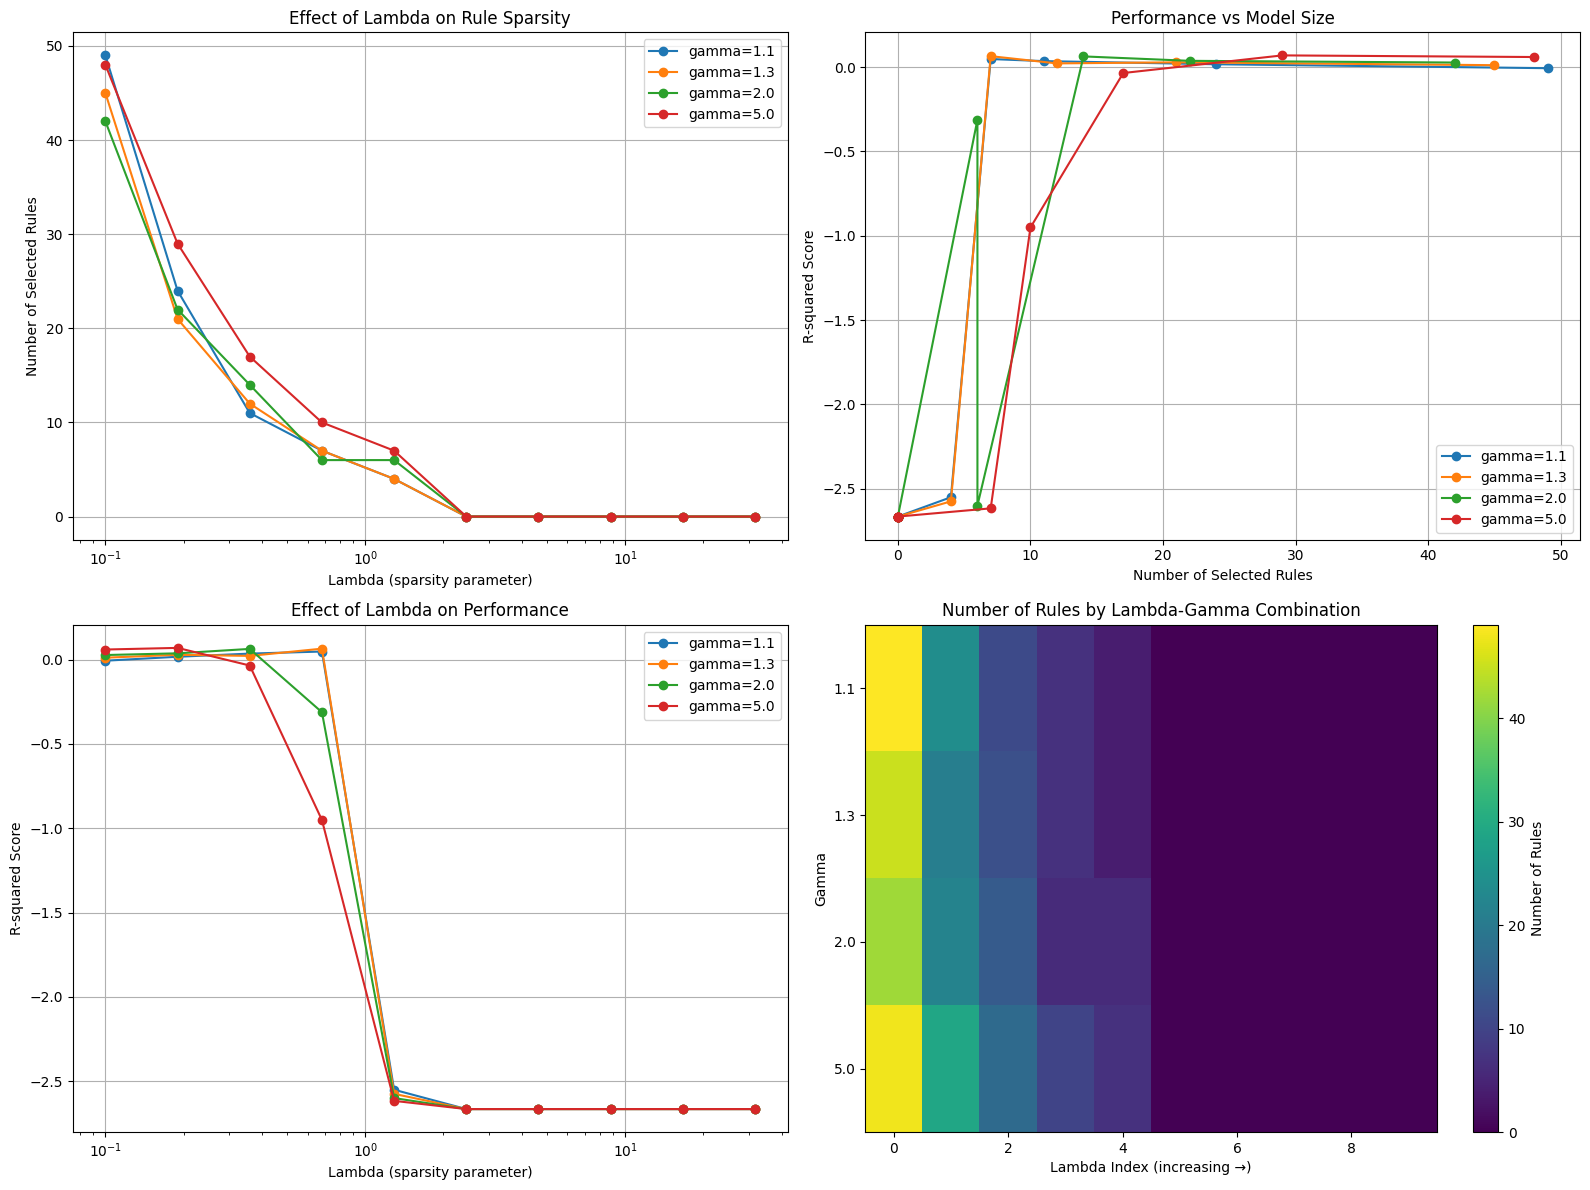

In [50]:
# Define hyperparameter ranges to test
# Using more values of gamma to better see its effect
gammas = [1.1, 1.3, 2.0, 5.0]  # From near-L0 to more like L1

# Using a higher range of lambda values to increase sparsity
lambdas = np.logspace(-1, 1.5, 10)  # Higher values will select fewer rules

# Storage for results
results = []

# Get rule matrices once (to avoid recomputing)
rule_matrix_train, _ = fire.get_rule_matrix_sparse(xTrain, rf.estimators_)
rule_matrix_test, _ = fire.get_rule_matrix_sparse(xTest, rf.estimators_)

# Run grid search
for gamma in gammas:
    for lambda1 in lambdas:
        print(f"Testing gamma={gamma}, lambda1={lambda1}")
        
        weights, _ = fire.MCP_CD(yTrain.values, rule_matrix_train.toarray(), 
                               lambda1, gamma)
        
        fire_pred = rule_matrix_test.toarray() @ weights
        r2_score = fire.r_squared(yTest, fire_pred, yTrain)
        num_rules = (weights != 0).sum()
        
        results.append({
            'gamma': gamma,
            'lambda1': lambda1,
            'r2_score': r2_score,
            'num_rules': num_rules
        })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Create visualizations
plt.figure(figsize=(16, 12))

# Plot 1: Number of rules vs lambda for different gammas
plt.subplot(2, 2, 1)
for gamma in gammas:
    subset = results_df[results_df['gamma'] == gamma]
    plt.plot(subset['lambda1'], subset['num_rules'], 'o-', label=f'gamma={gamma}')
plt.xscale('log')
plt.xlabel('Lambda (sparsity parameter)')
plt.ylabel('Number of Selected Rules')
plt.title('Effect of Lambda on Rule Sparsity')
plt.legend()
plt.grid(True)

# Plot 2: R2 score vs number of rules for different gammas
plt.subplot(2, 2, 2)
for gamma in gammas:
    subset = results_df[results_df['gamma'] == gamma]
    subset_sorted = subset.sort_values('num_rules')
    plt.plot(subset_sorted['num_rules'], subset_sorted['r2_score'], 'o-', label=f'gamma={gamma}')
plt.xlabel('Number of Selected Rules')
plt.ylabel('R-squared Score')
plt.title('Performance vs Model Size')
plt.legend()
plt.grid(True)

# Plot 3: R2 score vs lambda for different gammas
plt.subplot(2, 2, 3)
for gamma in gammas:
    subset = results_df[results_df['gamma'] == gamma]
    plt.plot(subset['lambda1'], subset['r2_score'], 'o-', label=f'gamma={gamma}')
plt.xscale('log')
plt.xlabel('Lambda (sparsity parameter)')
plt.ylabel('R-squared Score')
plt.title('Effect of Lambda on Performance')
plt.legend()
plt.grid(True)

# Plot 4: Heatmap of number of rules for different lambda-gamma combinations
plt.subplot(2, 2, 4)
pivot = results_df.pivot_table(index='gamma', columns='lambda1', values='num_rules')
plt.imshow(pivot, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Number of Rules')
plt.title('Number of Rules by Lambda-Gamma Combination')
plt.ylabel('Gamma')
plt.xlabel('Lambda Index (increasing →)')
gamma_labels = [f"{g:.1f}" for g in gammas]
plt.yticks(range(len(gammas)), gamma_labels)

plt.tight_layout()
plt.savefig('fire_hyperparameter_analysis_sparse.png')
plt.show()

In [51]:
# Find the most efficient configurations (best R2 per rule)
results_df['efficiency'] = results_df['r2_score'] / results_df['num_rules']
efficient_configs = results_df[results_df['num_rules'] > 5].sort_values('efficiency', ascending=False)
print("\nMost efficient configurations (best R2 per rule):")
print(efficient_configs.head(10))


Most efficient configurations (best R2 per rule):
    gamma   lambda1  r2_score  num_rules  efficiency
13    1.3  0.681292  0.065051          7    0.009293
3     1.1  0.681292  0.048062          7    0.006866
22    2.0  0.359381  0.063590         14    0.004542
2     1.1  0.359381  0.035767         11    0.003252
31    5.0  0.189574  0.069639         29    0.002401
12    1.3  0.359381  0.022135         12    0.001845
21    2.0  0.189574  0.037396         22    0.001700
11    1.3  0.189574  0.028641         21    0.001364
30    5.0  0.100000  0.059954         48    0.001249
1     1.1  0.189574  0.017024         24    0.000709


# Interpreting

In [52]:
def tree_to_code(tree, feature_names):
    """
    Convert a decision tree into a sequence of if-then statements
    """
    tree_ = tree.tree_
    # Create a safe mapping for feature names
    feature_name = []
    for i in tree_.feature:
        if i != _tree.TREE_UNDEFINED:
            # Check if the index is within bounds
            if i < len(feature_names):
                feature_name.append(feature_names[i])
            else:
                feature_name.append(f"feature_{i}")
        else:
            feature_name.append("undefined!")
            
    paths = []
    def recurse(node, depth, path):
        indent = " " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left_path = path.copy()
            left_path.append(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1, left_path)
            right_path = path.copy()
            right_path.append(f"{indent}if {name} > {threshold:.2f}:")
            recurse(tree_.children_right[node], depth + 1, right_path)
        else:
            path.append(f"{indent}return {np.round(tree_.value[node][0][0])}")
            paths.append(" ".join(path))
    recurse(0, 1, [])
    return paths

def rf_to_rules(tree_list, feature_names):
    paths_all = []
    for tree1 in tree_list:
        paths = tree_to_code(tree1, feature_names)
        for p in paths:
            paths_all.append(p)
    return paths_all

def get_rules(estimator, feature_names, weights):  # Added weights parameter
    all_rules = rf_to_rules(estimator, feature_names)
    sorted_selected_rules = sorted(
        [rule for rule, weight in zip(all_rules, weights) if weight != 0],
        key=lambda rule: float(rule.split("return")[-1].strip())  # Extract the return value
    )
    # Print the sorted final rule ensemble
    print("Final Rule Ensemble Extracted by FIRE (sorted by increasing return value)")
    for rule in sorted_selected_rules:
        print(rule)
    return sorted_selected_rules

def parse_rule_line(line):
    conditions = re.findall(r'if (.*?):', line)
    ret_match = re.search(r'return ([\-\d\.]+)', line)
    if not ret_match:
        raise ValueError(f"No return found in line: {line}")
    return_value = float(ret_match.group(1))
    return conditions, return_value

def insert_path(tree, conditions, return_value):
    if not conditions:
        tree["value"] = return_value
        return
    first_condition = conditions[0]
    if first_condition not in tree:
        tree[first_condition] = {}
    if True not in tree[first_condition]:
        tree[first_condition][True] = {}
    insert_path(tree[first_condition][True], conditions[1:], return_value)

def add_nodes(dot, tree, parent_id=None, edge_label=""):
    if "value" in tree:
        leaf_id = str(id(tree))
        dot.node(leaf_id, label=f"Return {tree['value']}", shape="box", style="filled", color="lightblue")
        if parent_id:
            dot.edge(parent_id, leaf_id, label=edge_label)
        return
    for condition, branch_dict in tree.items():
        node_id = str(id(condition))
        dot.node(node_id, label=condition, shape="ellipse", style="filled", color="lightgray")
        if parent_id:
            dot.edge(parent_id, node_id, label=edge_label)
        if True in branch_dict:
            add_nodes(dot, branch_dict[True], parent_id=node_id, edge_label="True")

def visualize_tree(tree, filename="decision_tree"):
    dot = graphviz.Digraph()
    add_nodes(dot, tree)
    dot.render(filename, view=True)

In [53]:
gamma, lambda1 = efficient_configs.iloc[0].gamma, efficient_configs.iloc[0].lambda1

weights, _ = fire.MCP_CD(yTrain.values, rule_matrix_train.toarray(), lambda1, gamma)
fire_pred = rule_matrix_test.toarray()@weights

rules = get_rules(rf.estimators_, X.columns, weights)

Final Rule Ensemble Extracted by FIRE (sorted by increasing return value)
 if cancer_type <= -0.93:   if rpgr > 0.72:    return 36.0
 if cancer_type <= -0.93:   if tgfb2 <= -1.40:    return 52.0
 if age_at_diagnosis > 0.77:   if mtap_mut <= 0.50:    return 59.0
 if akt1_mut > 0.50:   if cohort > -0.21:    return 91.0
 if akt1_mut > 0.50:   if cohort <= -0.21:    return 130.0
 if akt1_mut <= 0.50:   if hsd17b7 > -0.90:    return 137.0
 if akt1_mut <= 0.50:   if hsd17b7 <= -0.90:    return 219.0


In [54]:
decision_tree = {}
for line in rules:
    conds, val = parse_rule_line(line)
    insert_path(decision_tree, conds, val)

visualize_tree(decision_tree, filename="my_decision_tree")